# Transfer Learning Model

In [2]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img
import numpy as np
import os
import matplotlib.pyplot as plt

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

## Pre-trained neural networks

I trained a scratch model that was 6 layers deep. There are models available that are for more complex e.g. Xception is a convolutional neural network that is 71 layers deep. There is a version of Xception that has been trained on over a million images from the ImageNet database. This model can classify images into 1000 object categories, such as keyboard, mouse, pencil, and many animals. 

We know that the initial Convolutional layers are dedicated to feature extraction. This network has learned rich feature representations for a wide range of images and although it doesn't focus on emotion recognition, its convolutional layers may prove better at analysing the subtleties of images than our scratch model. 

### Xception model requirements

Xception has specific input size requirements: 299 x 299 pixels and RGB images. Our images are 48 x 48 and grayscale. Resizing the image would create a lot of distortion. It is possible to pad the images (add black borders).

### MobileNet

Unlike Xception, MobileNet can handle smaller image dimensions without padding. It is optimized for mobile and embedded devices where memory and processing power are constrained. It doesn't perform as well as more complex models like Xception or EfficientNet. Then again MobileNet has been shown to work well with smaller inputs. The smallest supported size is 32 x 32. We can use the latest model: MobileNetV3-Small.

In other Keras Applications, a specific kind of input preprocessing is required but for MobileNetV3 default input preprocessing is included as part of the model e.g. often the preprocessing layer scales the image down to have pixels in a range [0,1]. In this model however, it expects pixels with values in the [0-255] range. The only thing we have to do to our image is deal with its grayscale nature


## Test running the current MobileNetV3_Small model

Below we prepare a sample image for the MobileNetV3_Small model that has already been trained on imagenet. 

We need to resize the image to (244,244) and you can see that there is a loss of fidelity when we do this.

You can also see that the pretrained model's best guess of this image is that it is an oboe! This is because the ImageNet dataset classifies objects, not faces. 

We can use the feature extraction learning gleaned in earlier layers and modify the later layers for our specific visualisation task.

In [22]:
def preprocess_input(image_path, resize_dimensions=(48,48)):
    """Preprocess Input"""
    try:
        image_file = tf.io.read_file(image_path)
    except:
        print(f"Issue loading {image_file}")
        return None

    image = tf.image.decode_jpeg(image_file, channels=1)
    image = tf.image.grayscale_to_rgb(image)
    image = tf.image.resize(image, resize_dimensions)
        
    return image

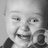

In [19]:
happy_image_path = '../data/clean_fer_2013/train/happy/Training_109676.jpg'
img = load_img(happy_image_path, color_mode="grayscale")
img

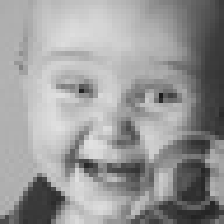

In [21]:
load_img(happy_image_path, color_mode="rgb", target_size=(224,224))

In [23]:
np.array(img).shape, preprocess_input(happy_image_path).shape

((48, 48), TensorShape([48, 48, 3]))

In [25]:
np.array(img).shape, preprocess_input(happy_image_path, resize_dimensions=(224,224)).shape

((48, 48), TensorShape([224, 224, 3]))

In [34]:
example_model = keras.applications.MobileNetV3Small(
    weights="imagenet",
    input_shape=(224,224,3)
)

x = preprocess_input(happy_image_path, resize_dimensions=(224,224))
X = np.expand_dims(x, axis=0)
prediction = example_model.predict(X)
prediction.shape

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


(1, 1000)

In [35]:
X.shape

(1, 224, 224, 3)

In [37]:
keras.applications.mobilenet_v3.decode_predictions(prediction)

[[('n03838899', 'oboe', 0.19695884),
  ('n03692522', 'loupe', 0.13229725),
  ('n04591157', 'Windsor_tie', 0.06434186),
  ('n04317175', 'stethoscope', 0.048217747),
  ('n02804610', 'bassoon', 0.046077013)]]

## Transfer Learning

I will do the following to make use of MobileNetV3Small for our data:

1. Instantiate a base model and load pre-trained weights into it.
2. Freeze all layers in the base model by setting trainable = False.
3. Create a new model on top of the output of one (or several) layers from the base model.
4. Train your new model on your new dataset.

You can see that the model has far more parameters than our scratch model but the actual trainable parameters are significantly reduced. This makes sense: we have frozen our base model and it has already been trained. We are only training the dense layer we added.

In [53]:
# 1. Instantiate base model and load pre-trained weights, specify our preferred input shape
base_model = keras.applications.MobileNetV3Small(
    weights="imagenet", # Load weights pretrained on Imagenet
    input_shape=(48,48,3),
    include_top=False # Do not include the ImageNet classifier at the top
)

# 2. Freeze the base model
base_model.trainable = False 

# 3. Create a new model on top of the output on one of the layers
inputs = keras.Input(shape=(48,48,3))

base = base_model(inputs, training=False)
vectors = keras.layers.GlobalAveragePooling2D()(base)

# Final output layer
num_categories = 7
outputs = keras.layers.Dense(num_categories, activation='softmax')(vectors)

first_model = keras.Model(inputs,outputs) 

optimizer = keras.optimizers.Adam(learning_rate=0.001)

loss = keras.losses.CategoricalCrossentropy(from_logits=False)

first_model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
first_model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_17 (InputLayer)     │ (None, 48, 48, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MobileNetV3Small (Functional)   │ (None, 2, 2, 576)      │       939,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_10     │ (None, 576)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │         4,039 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 943,159 (3.60 MB)

 Trainable params: 4,039 (15.78 KB)

 Non-trainable params: 939,120 (3.58 MB)

### Loading the datasets and training the model

I am using the same functionality as in the scratch model to load our validation and training datasets.

In [43]:
def get_image_meta(data_path):
    """Retrieve basic metadata (file_path, category)"""
    
    file_meta = []

    for name in os.listdir(data_path): 
        filepath = os.path.join(data_path, name)

        if '.DS_Store' in filepath:
            continue

        for image_file_name in os.listdir(filepath): 
            image_filepath = os.path.join(filepath, image_file_name)

            attrs = {
                'category': name,
                'file_path': image_filepath,
            }
            file_meta.append(attrs)

    return file_meta 

In [44]:
data_file_path = "../data/clean_fer_2013/"

In [45]:
train_data_folder = data_file_path + "train/"

meta_train = get_image_meta(train_data_folder)

df_meta_train = pd.DataFrame(meta_train)
df_meta_train.head()

,category,file_path
0,happy,../data/clean_fer_2013/train/happy/Training_50...
1,happy,../data/clean_fer_2013/train/happy/Training_70...
2,happy,../data/clean_fer_2013/train/happy/Training_85...
3,happy,../data/clean_fer_2013/train/happy/Training_44...
4,happy,../data/clean_fer_2013/train/happy/Training_63...


In [46]:
val_data_folder = data_file_path + "validation/"

meta_val = get_image_meta(val_data_folder)

df_meta_val = pd.DataFrame(meta_val)
df_meta_val.head()

,category,file_path
0,happy,../data/clean_fer_2013/validation/happy/Public...
1,happy,../data/clean_fer_2013/validation/happy/Public...
2,happy,../data/clean_fer_2013/validation/happy/Public...
3,happy,../data/clean_fer_2013/validation/happy/Public...
4,happy,../data/clean_fer_2013/validation/happy/Public...


In [47]:
def create_label_encoder(categories):
    """Create a mapping from category names to integer indices and perform one hot encoding"""
    return tf.keras.layers.StringLookup(vocabulary=categories, 
                                                output_mode='one_hot', 
                                                num_oov_indices=0)

def create_dataset(image_paths, labels, label_encoder, batch_size=32):
    """Load the dataset from file paths, apply preprocessing and group into batches"""
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    dataset = dataset.map(lambda x, y: (preprocess_input(x), tf.squeeze(label_encoder(y))))
    dataset = dataset.batch(batch_size)
    dataset = dataset.shuffle(buffer_size=1000)  # Shuffle the dataset
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)  # Prefetch for better performance
    return dataset

In [48]:
train_labels = df_meta_train["category"].values
train_image_paths = df_meta_train["file_path"].values

val_labels = df_meta_val["category"].values
val_image_paths = df_meta_val["file_path"].values

categories = list(df_meta_train["category"].unique())
label_encoder = create_label_encoder(categories)

train_dataset = create_dataset(train_image_paths, train_labels, label_encoder, batch_size=32)
val_dataset = create_dataset(val_image_paths, val_labels, label_encoder, batch_size=32)

In [49]:
expected_num_iterations_per_epoch = len(train_dataset)
length_training_data = len(train_dataset) * 32
length_validation_data = len(val_dataset) * 32

expected_num_iterations_per_epoch, length_training_data, length_validation_data

(837, 26784, 3488)

In [54]:
history = first_model.fit(
    train_dataset,          
    epochs=30,           
    validation_data=val_dataset  
)

Epoch 1/30
837/837 ━━━━━━━━━━━━━━━━━━━━ 23s 15ms/step - accuracy: 0.2554 - loss: 1.8475 - val_accuracy: 0.2996 - val_loss: 1.7619
Epoch 2/30
837/837 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - accuracy: 0.2715 - loss: 1.8033 - val_accuracy: 0.3220 - val_loss: 1.7297
Epoch 3/30
837/837 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - accuracy: 0.3018 - loss: 1.7395 - val_accuracy: 0.2936 - val_loss: 1.8067
Epoch 4/30
837/837 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - accuracy: 0.3095 - loss: 1.7540 - val_accuracy: 0.3168 - val_loss: 1.7557
Epoch 5/30
837/837 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - accuracy: 0.3228 - loss: 1.7252 - val_accuracy: 0.3269 - val_loss: 1.7148
Epoch 6/30
837/837 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step - accuracy: 0.3417 - loss: 1.6694 - val_accuracy: 0.3249 - val_loss: 1.7120
Epoch 7/30
837/837 ━━━━━━━━━━━━━━━━━━━━ 16s 14ms/step - accuracy: 0.3522 - loss: 1.6539 - val_accuracy: 0.3499 - val_loss: 1.6603
Epoch 8/30
837/837 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step - accuracy: 0.3553 - loss: 1.6553 - 

**Evaluation**

The initial results are not too promising: it is strange that the training set is struggling to get better accuracy than 37%!

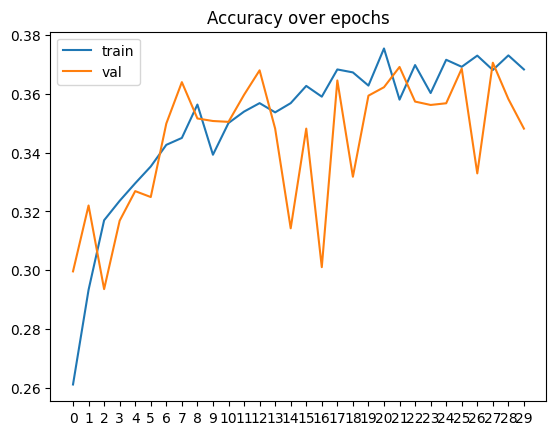

In [55]:
plt.plot(history.history["accuracy"], label="train")
plt.plot(history.history["val_accuracy"], label="val")
plt.xticks(np.arange(30))
plt.legend()
plt.title("Accuracy over epochs")
plt.show()

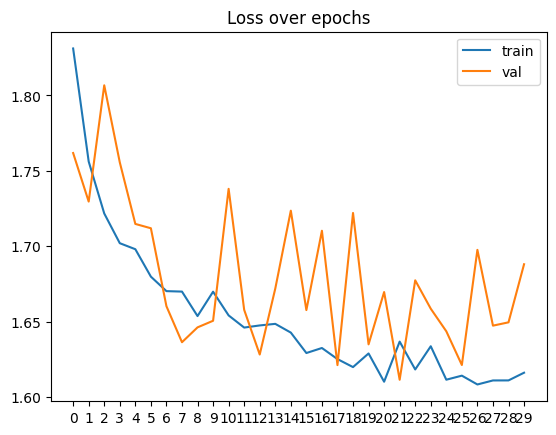

In [56]:
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="val")
plt.xticks(np.arange(30))
plt.legend()
plt.title("Loss over epochs")
plt.show()